In [ ]:
import astropy.units as u
import astropy.constants as c

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('/home/daniel/repositories/burst-style/burst.mplstyle')

It is widely believed that short Gamma-ray bursts (sGRB) are produced by compact binary coalescence (CBCs), and observations suggest that the coalescing systems likely to produce them are binary neutron star systems (BNS systems), or neutron star-black hole binaries (NSBH systems). At the full design sensitivity of advanced LIGO these may be visible to a distance of 400 Mpc for NSNS and 1 Gpc for NSBH.

Given this link between sGRBs and CBC events, it is interesting to ask if the beaming angle of the radiation from the GRB can be inferred from gravitational wave (GW) observations.

If the sGRB population has a distribution of beaming angles then the observed rate is related to the BNS coalescence rate, $\mathcal{R}$, by 
\\[ \mathcal{R}_{\text{GRB}} = \epsilon \mathcal{R} \langle 1 - \cos(\theta) \rangle \\]


| Symbol | Name | Note |
| ------ | ---- | ---- |
| $\epsilon$ | efficiency | the probability that the BNS produces a GRB |
| $\mathcal{R}_{\text{GRB}}$ | GRB rate | the observed rate of GRBs |
| $\mathcal{R}$ | BNS merger rate | the observed rate of BNS CBCs |
| $\theta$ | beaming angle | the angle which radiation is beamed from the GRB |


EM observations suggest that beaming angles have a distribution, so the raltive rates of sGRBs and CBCs should provide the mean of that population, $\langle \theta \rangle$.

In [ ]:
@u.quantity_input(bns_rate=1/u.year, theta=u.degree)
def rate_grb(efficiency, theta, bns_rate):
    """
    Calculate the rate of gamma ray bursts from the rate of BNS coalescence.
    
    efficiency : float
        The efficiency of GRB production.
    theta : float
        The beaming angle
    bns_rate : The rate of BNS mergers
    
    """
    return efficiency * bns_rate * (1- np.cos(theta))

@u.quantity_input(grb_rate=1/u.year, theta=u.degree)
def rate_cbc(efficiency, theta, grb_rate):
    """
    Calculate the rate of CBCs from the GRB rate.
    """
    return grb_rate / (efficiency*(1.0 - np.cos(theta)))

## The sGRB population mean

Here we show the impact of BNS mergers on sGRBs, with the following proceedure:

* We set the number of observed GRBs to zero: $N_{\text{GRB}} = 0$

In [ ]:
Ngrb = 0

* We draw $N_{\text{BNS}}$ values for orbital inclination, $\iota$ from a distribution uniform in $\cos(\iota)$ over the range $[0,1]$.

In [ ]:
import numpy as np
Nbns = 1e5 
iotas = np.arccos( 0 + 1*np.random.rand(Nbns) )
# to degrees
iotas *= 180/np.pi

* For each $\iota$ draw a $\theta$ from a distribution over $(0,90]^\circ$
* Iff $\iota < \theta$ the event is observable: increment $N_{\text{GRB}}$

In [ ]:
theta_mu=np.arange(5,35,5)
theta_sigma=np.arange(1,16)
theta_low=0.01
theta_upp=90

In [ ]:
def truncparms(low,upp,mu,sigma):
    a = (low - mu) / sigma
    b = (upp - mu) / sigma
    return a, b

In order to calculate the efficiency we take 

\\[ \epsilon = \frac{ N_{\text{GRB}} + 1 }{N_{\text{BNS}} + 2 } \\]


In [ ]:
def compute_efficiency(k,N,b=True):

    if b:
        # Bayesian treatment
        epsilon=(k+1)/(N+2)
        stdev_epsilon=1.64*np.sqrt(epsilon*(1-epsilon)/(N+3))
    else:
        # Binomial treatment
        if N==0:
            epsilon=0.0
            stdev_epsilon=0.0
        else:
            epsilon=k/N
            stdev_epsilon=1.64*np.sqrt(epsilon*(1-epsilon)/N)
    return (epsilon,stdev_epsilon)

We'll draw all of the beaming angles from a truncated normal distribution, and we'll run the simulation for a variety of differently shaped distribution.

In [ ]:
import scipy.stats as stats

FracGRB=np.zeros((len(theta_mu),len(theta_sigma)))
deltaFracGRB=np.zeros((len(theta_mu),len(theta_sigma)))

for m,mu, in enumerate(theta_mu):
    for s,sigma in enumerate(theta_sigma):
        a, b = truncparms(theta_low, theta_upp, mu, sigma)
        thetas = stats.truncnorm.rvs(a, b, loc=mu, scale=sigma, size=Nbns)
        # Count GRBs
        Ngrbs=sum(iotas <= thetas)
        
        FracGRB[m,s], deltaFracGRB[m,s] = compute_efficiency(Ngrbs,Nbns)

A population of sGRB beaming angles with a large mean but a narrow width is indistinguishable from the converse, as can be seen in the plot below, where $\mathcal{N}(15,8)$ and $\mathcal{N}(10,12)$ both give the same number ratio (see the light grey line).

In [ ]:
linestyles=['-', '-', '-']
markers=['s', '^', 'o']

f, ax = plt.subplots(1,1)

ax.hlines(FracGRB[1,11]*100,0,16, lw=1, color='gray', alpha=0.5)
for i in range(len(theta_mu)):
    ax.plot(theta_sigma, FracGRB[i]*100, #deltaFracGRB[i]*100, 
                 linestyle=linestyles[i%3], lw=2,# c='k',
                 #marker=markers[i%3], markeredgecolor='white', 
                #label=r"$\langle \theta \rangle = {}$".format(theta_mu[i])
                )
    ax.annotate("{}".format(theta_mu[i]), (15.1, .1+FracGRB[i][-1]*100))
ax.set_ylim(0,18.5)
ax.annotate(r"$\langle \theta \rangle$", (15, 17.6))
ax.set_ylabel(r"$N_{\rm{GRB}} / N_{\rm{BNS}}$ [%]")
ax.set_xlabel(r"$\sigma_{\theta}$ [degree]")
plt.tight_layout()
plt.savefig('color_relativenumber.pdf')

txt = """Expected relative numbers of observed GRBs and binary coalescences for different 
distributions on the GRB beaming angle. Lines in the figure correspond to jet angle
population means, while the x-axis shows the width of the distribution. All distributions are 
Gaussian, truncated at (0, 90] degrees."""
f.text(.1,-.15,txt)

This has the effect of a wide distribution of beaming angles producing an under-estimate of the beaming angle, so population-based constraints must be regarded as upper-bounds.

## Rates to Beaming Angle

The general method to move from a rate to a beaming angle is

### Estimate the posterior distribution on the BNS merger rate from observed GW signals

Gravitational wave detectors identify discrete 'events' which are characterised by their *network signal-to-noise ratios*, $\rho_{\mathrm{c}}$

We begin by constructing the posterior on the signal rate; the measured rate, $r$ of events has two components, the signal rate, $s$, and the background rate, $b$:

\\[ r = s+b\\]

Typically a threshold of $\rho \ge 12$ is applied to analysis, placing $b = 10^{-2}$ per year, so only the signal rate needs to be inferred.

Taking a uniform prior on $s$, and assuming the events are generated by a Poisson process, it can be shown that the rate posterior depends only on the number of detected signals, $n$, the observation time, $T$, the background rate, $b$, and the horizon distance, $\mathcal{D}$ (the maximum distance at from which a detection can be made).

The posterior will then be

\\[
   p(s|n,b,I) = C \frac{T[(s+b) T]^n e^{-(s+b)T}}{n!} 
\\]

for
\begin{align*}
    C^{-1} &= \frac{e^{-bT}}{n!} \int_0^\infty {\rm d}(sT)(s+b)^n T^n e^{-sT} \\
           &= \sum_{i=0}^n \frac{ (bT)^i e^{-bT} }{i!} 
\end{align*}

In [ ]:
@u.quantity_input(s=1/u.year, 
                  b=1/u.year,
                  T=1*u.year)
def signal_posterior(s, b, n, T):
    """
    The event rate posterior assuming that a Poisson process underlies 
    the production of gravitational wave events.
    
    s : float
        The event rate
    n : float
        The number of events observed over the timespan of the observing run
    b : float
        The background rate of events
    T : float
        The total time of the observing run
    """
    # Calculate the inverse of C
    C_inv = np.sum([ (b*T)**i * np.exp(-b*T) / np.math.factorial(i) 
                    for i in xrange(n) ])
    # Then invert it
    C = 1. / C_inv
    # Calculate the posterior piece-wise
    p1 = T * ((s+b)*T)**n * np.exp( - (s+b) * T)
    p2 = np.math.factorial(n)
    return C * p1 / p2

Let's have a quick look at a plot of this.

In [ ]:
s = np.linspace(0,10, 11)/u.year
b = 10 / u.year #np.linspace(0,10, 11)/u.year
T = 1 * u.year
plt.plot(s, signal_posterior(s, b, 10, T))

We'll want to express the rate in terms of the number of mergers per *milky-way equivalent galaxy*, or MWEG. We can approximate the number of MWEGS inside the sensitivity range of the detectors as
\\[
    N_{\mathrm{G}} = \frac{4}{3} \pi \left( \frac{\mathcal{D}}{\mathrm{Mpc}} \right)^3 
    (2.26)^{-3}
    (0.0116)
\\]

In [ ]:
@u.quantity_input(horizon=u.megaparsec)
def n_mweg(horizon):
    mweg1 = (4. / 3. ) * np.pi 
    mweg2 = (horizon / 1/u.megaparsec)**3
    mweg3 = (2.26)**(-3) * 0.0116
    return mweg1 * mweg2 * mweg3

This let's us reach the posterior on the binary coalescence rate:
\begin{align*}
    p(\mathcal{R} | s,n,T,b,\mathcal{D}) &= p(s|n,T,b) \left| \frac{\mathrm{d}s}{\mathrm{d}\mathcal{R}} \right| \\
                                       &= N_{\mathrm{G}} \mathcal{D} \ p(s |n,T,b)
\end{align*}

In [ ]:
@u.quantity_input(s=1/u.year, 
                  b=1/u.year,
                  T=1*u.year, 
                  horizon=u.megaparsec)
def rate_posterior(s, b, n, T, horizon):
    """
    
    """
    nmweg = n_mweg(horizon)
    post = signal_posterior(s,b,n, T)
    return nmweg * post

In [ ]:
s = np.linspace(0,10, 11)/u.year
b = 10 / u.year #np.linspace(0,10, 11)/u.year
T = 1 * u.year
horizon = 100*u.megaparsec
plt.plot(s, rate_posterior(s, b, 10, T, horizon))

These quantities define our *detection scenarios*.


| Scenario name | $T$ | $\mathcal{D}$ | $V$    | $\mathcal{R}$ | $n$ |
| ------------- | --- | ------------- | ------ | ------------- | --- |
| 2016          | 0.5 | 80 - 120      | 1.05e6 | 1e-6          | 1.3 |
| 2022+         | 1.0 | 200           | 4.00e7 | 1e-6          | 40  |

### Transform from the rate posterior to an angle posterior

Inferences of the GRB beaming angle are made from the posterior on the beaming angle, so we need to convert a posterior on the rate prior into a posterior on the angle. To do this we use a Jacobian.

\\[ p(\theta, \epsilon) = p(\mathcal{R}, \epsilon) \left|\left| \frac{ \partial(\mathcal{R},\epsilon) }{ \partial (\theta, \epsilon) } \right|\right| \\]

We assume that the beaming angle and the rate are probabilistically independent, so

\\[ p(\theta) = \frac{2 \mathcal{R}_{\rm GRB}  \sin \theta \ p(\mathcal{R})  }{( \cos \theta - 1)^2 } \int \frac{p(\epsilon) {\rm d} \epsilon }{\epsilon}  \\]

In [ ]:
def jacobian(efficiency, theta, grb_rate):
    denom=efficiency*(np.cos(theta * np.pi/180)-1)
    return abs(2.0*grb_rate * np.sin(theta * np.pi / 180.0) /
                (denom*denom) )

So for a given efficiency, $\epsilon$ and beaming angle $\theta$ the CBC rate needs to be found, then the rate posterior for this calculated, and finally rotated using the Jacobian.

In [ ]:
from grbeams.distributions import UniformDistribution

In [ ]:
def p_theta(theta, efficiency, grb_rate, theta_range=(0*u.degree,90*u.degree)):
    if (theta>=min(theta_range)) and (theta<max(theta_range)):
        bns_rate = rate_cbc(efficiency, theta, grb_rate)
        j = jacobian(efficiency, theta, grb_rate).value
        p_efficiency = UniformDistribution(range=(0,1.0))
        return bns_rate.value + np.log(j) + np.log(p_efficiency.pdf(efficiency))
    else:
        return -np.inf

We can sample from the beaming angle posterior using MCMC; we sample points from the $p(\theta, \epsilon)$ distribution, and then perform kernel-density estimation. The mode of the KDE is the MAP estimate, with the lower and upper bounds found from the 95% confidence intervals.

## A Rate posterior using the upper limit in the NSBH paper draft

In [8]:
class LimitToFile:
    """
    class with the observing scenario information for the null detection run and
    an upper limit from the loudest event formalism
    """

    def __init__(self, rate_upper_limit=1.3e-4, alpha=0.9):
        self.upper_limit = rate_upper_limit
        self.eps = -1*np.log(1-alpha)/rate_upper_limit

    def comp_bns_rate_pdf(self, bns_rate):
        return cbcRatePosteriorNull(self.eps, bns_rate)

    def compute_posteriors(self):
        # BNS coalescence rate posterior arrays for rate in / Mpc^3 / Myr.
        self.bns_rate=np.linspace(1e-8,5e-4,5000)
        self.bns_rate_pdf = self.comp_bns_rate_pdf(self.bns_rate)

    def dump_posterior(self, filename="bns_rate_posterior.txt"):

        f = open(filename, 'w')
        for rate, pdf in zip(self.bns_rate, self.bns_rate_pdf):
            f.writelines("{0} {1}\n".format(rate, pdf))
        f.close()

## Prospects for detecting with aLIGO

In [1]:
from grbeams.scenarios import Scenario, BNSDistribution
from grbeams.beamingangle import BeamingAnglePosterior
from grbeams.distributions import DeltaDistribution, UniformDistribution, JeffreyDistribution
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('/home/daniel/repositories/burst-style/burst.mplstyle')
import astropy.units as u

/home/daniel/.virtualenvs/jupyter/lib/python2.7/site-packages/matplotlib/__init__.py:1069: UserWarning: Bad val "True," on line #7
	"text.usetex: True,
"
	in file "/home/daniel/repositories/burst-style/burst.mplstyle"
	Key text.usetex: Could not convert "true," to boolean
  (val, error_details, msg))
/home/daniel/.virtualenvs/jupyter/lib/python2.7/site-packages/matplotlib/__init__.py:1069: UserWarning: Bad val "black," on line #9
	"text.color          : black,
"
	in file "/home/daniel/repositories/burst-style/burst.mplstyle"
	Key text.color: black, does not look like a color arg
Color tuples must be length 3
  (val, error_details, msg))


In [3]:
rateunits = u.gigaparsec**-3*u.year**-1
data = np.loadtxt('bns_highspin_pycbc_unlam_lnvt.txt')
rate, pdf = (data[:,0])*rateunits, data[:,1]*rateunits**-1
bns_prior = BNSDistribution(rate, pdf  / (rate*pdf).sum() )

/home/daniel/.virtualenvs/jupyter/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u"'New Century Schoolbook'"] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


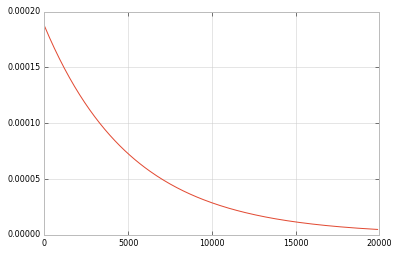

In [4]:
plt.plot(rate, pdf)

In [5]:
new_rate = u.megaparsec**-3*u.megayear**-1

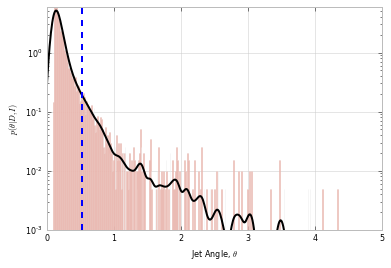

In [48]:
plt.figure()

plt.style.use('/home/daniel/repositories/burst-style/burst.mplstyle')
#o1scenario = Scenario(bns_prior)

#posterior = BeamingAnglePosterior(o1scenario, efficiency_prior=DeltaDistribution(1), grb_rate=3/u.gigaparsec**3 / u.year)
#chain = posterior.sample_theta_posterior(nburnin=1000, nsamp=200)
# Calculate the bandwidth of the poserior for the KDE
#theta_bw = 1.06*np.std(posterior.theta_samples)*len(posterior.theta_samples/100)**(-0.2)
#posterior.get_theta_pdf_kde(theta_bw)
theta_bin_size = 3.5*np.std(posterior.theta_samples) \
        / len(posterior.theta_samples)**(1./2)
#theta_bins = np.arange(posterior.theta_range.min(), posterior.theta_range.max(),
#        theta_bin_size)
theta_bins = np.linspace(0,10, 1000)
plt.hist(posterior.theta_samples, bins=theta_bins, log=True,  normed=True, alpha=1)
plt.plot(posterior.theta_grid,posterior.theta_pdf_kde, \
        color='k')
plt.axvline(np.percentile(posterior.theta_samples, 95.0), linestyle='--')
plt.ylim([1e-3, 6])
plt.xlim([0,5])
plt.xlabel(r'Jet Angle, $\theta$')
plt.ylabel(r'$p(\theta | D,I)$')

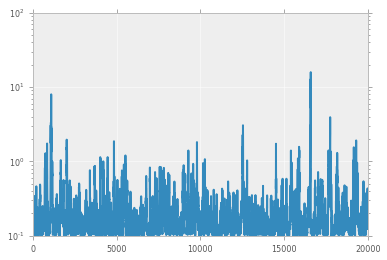

In [40]:
plt.semilogy(chain);

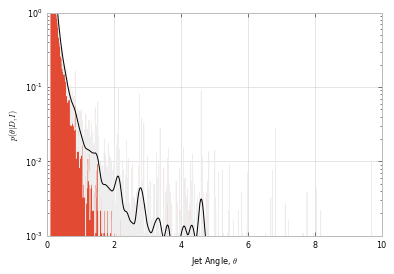

In [37]:
plt.figure()


o1scenario = Scenario(bns_prior)

#posterior = BeamingAnglePosterior(o1scenario, efficiency_prior=UniformDistribution(), grb_rate=3/u.gigaparsec**3 / u.year)
#chain = posterior.sample_theta_posterior(nburnin=2000, nsamp=4000)
# Calculate the bandwidth of the poserior for the KDE
theta_bw = 1.06*np.std(posterior.theta_samples)*len(posterior.theta_samples)**(-0.2)
posterior.get_theta_pdf_kde(theta_bw)
theta_bin_size = 3.5*np.std(posterior.theta_samples) \
        / len(posterior.theta_samples)**(1./2)
theta_bins = np.arange(0, posterior.theta_range.max(),
        theta_bin_size)
plt.hist(posterior.theta_samples, bins=theta_bins, normed=True, log=True, histtype='stepfilled',
        )
plt.plot(posterior.theta_grid,posterior.theta_pdf_kde, \
        color='k')
#plt.axvline(np.percentile(posterior.theta_samples, 99.9), linestyle='--')
plt.ylim([1e-3, 1])
plt.xlim([0,10])
plt.xlabel(r'Jet Angle, $\theta$')
plt.ylabel(r'$p(\theta | D,I)$')

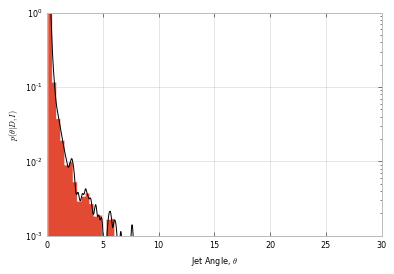

In [25]:
#posterior = BeamingAnglePosterior(o1scenario, efficiency_prior=JeffreyDistribution(), grb_rate=3/u.gigaparsec**3 / u.year)
#chain = posterior.sample_theta_posterior(nburnin=1000, nsamp=2000)

plt.figure()
theta_bw = 1.06*np.std(posterior.theta_samples)*len(posterior.theta_samples)**(-0.2)
posterior.get_theta_pdf_kde(theta_bw)
theta_bin_size = 3.5*np.std(posterior.theta_samples) \
        / len(posterior.theta_samples)**(1./3)
theta_bins = np.arange(posterior.theta_range.min(), posterior.theta_range.max(),
        theta_bin_size)
plt.plot(posterior.theta_grid,posterior.theta_pdf_kde, \
        color='k')
plt.hist(posterior.theta_samples, bins=100, normed=True, log=True, histtype='stepfilled',
        )
#plt.axvline(np.percentile(posterior.theta_samples, 99.), linestyle='--')
plt.ylim([1e-3, 1])
plt.xlim([0,30])
plt.xlabel(r'Jet Angle, $\theta$')
plt.ylabel(r'$p(\theta | D,I)$')